# MC approaches

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from time import perf_counter

Let us first implement Black-Scholes formula whose result will be compared with the Asian call prices we find, for information.

In [2]:
def vanilla(
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> float:
    '''Returns the price of a vanilla call with the specified parameters under Black-Scholes model'''
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

## 1. Naive approach

In [3]:
def naive(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float, float]:  # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    means = s[:-1, ::].mean(axis=0)             # estimatation of the mean value of the underlying
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    return c.mean(), 1.96*c.std()/np.sqrt(n)

### Results for varying strike $K$

In [4]:
fixed_n, fixed_m, fixed_r, fixed_S0 = 10**4, 100, .03, 100
Ks = np.linspace(90, 110, 11)

start = perf_counter()

result = {}
for fixed_T in [1/12, 1]:
    for fixed_sigma in [.15, .25]:
        fixed = []
        for K in Ks:
            est, ci = naive(fixed_n, fixed_m, fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
            bs = vanilla(fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
            fixed.append([est, bs, ci])
        fixed = np.array(fixed)
        result[(fixed_T, fixed_sigma)] = fixed

dur = perf_counter() - start
print(f'Duration: {dur:.2f} s')

Duration: 2.77 s


In [5]:
def plot_approach(res: np.ndarray, K_list: list, sigma_list: list, T_list: list):
    fig, ax = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)
    for i, T in enumerate(T_list):
        for j, sigma in enumerate(sigma_list):
            f = res[(T, sigma)]
            ax[i, j].plot(K_list, f[:, 1], color='tab:orange', linestyle='--', label='European call Black-Scholes price')
            ax[i, j].plot(K_list, f[:, 0], color='black', label='Asian call naive approach price')
            ax[i, j].scatter(K_list, f[:, 0] + f[:, 2], marker='v', color='tab:red')
            ax[i, j].scatter(K_list, f[:, 0] - f[:, 2], marker='^', color='tab:red', label='Confidence interval')
            ax[i, j].grid()
            ax[i, j].legend()
            if i==0:
                ax[i, j].annotate(f'$\sigma = {int(sigma*100)}\%$', xy=(0.5, 1), xytext=(0, 10),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
            elif i==1:
                ax[i, j].set_xlabel(r'Strike (% of the spot)')
                ax[i, j].set_xticks([90 + 5*k for k in range(5)], [90 + 5*k for k in range(5)])
            if j==1:
                row_lab = '$T = 1$m' if i==0 else '$T = 1$y'
                ax[i, j].annotate(row_lab, xy=(1, 0.5), xytext=(30, 0),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
    fig.tight_layout();

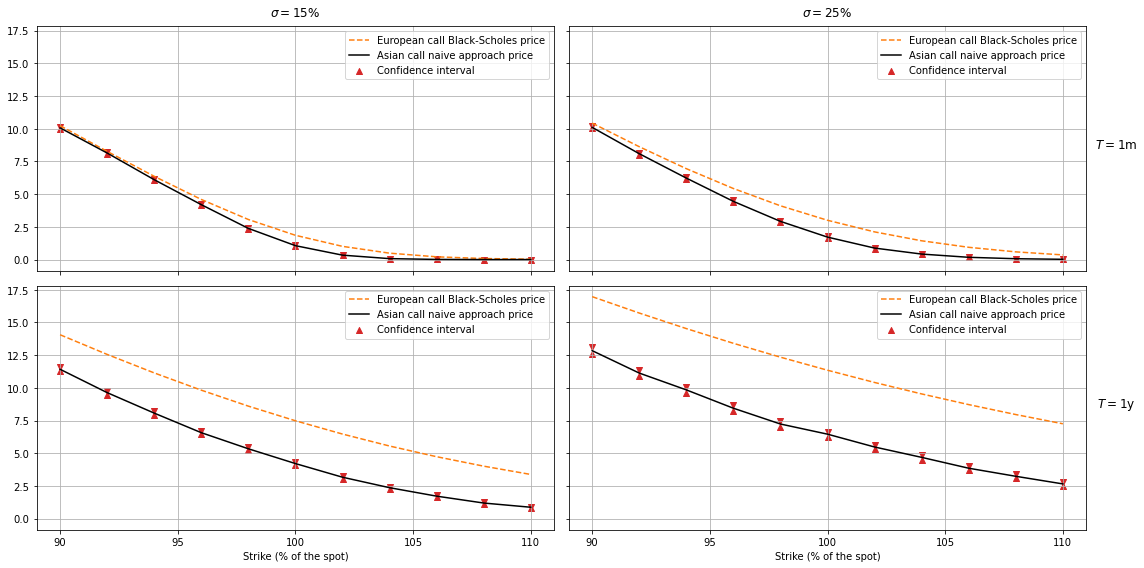

In [6]:
plot_approach(result, Ks, [.15, .25], [1/12, 1])

### Convergence properties

__Problem__: the above chart only shows the statistical error and not the discretization bias. As $\sqrt{n} \sim m$, they should be quite similar.

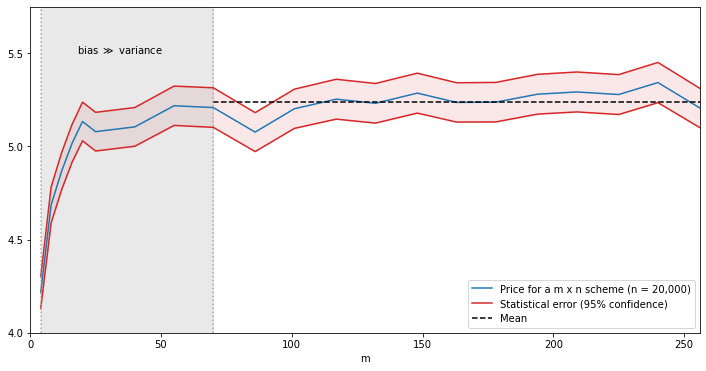

In [7]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 2*10**4, .03, 100, 1, .2, 100

ms = np.concatenate([np.linspace(4, 25, 6), np.linspace(40, 256, 15)]).astype('int')
fixed = []
for m in ms:
    est, ci = naive(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
    fixed.append([est, ci])
bs = vanilla(fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
fixed = np.array(fixed)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ms, fixed[:, 0], label=r'Price for a m x n scheme (n = 20,000)')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:red', label=r'Statistical error (95% confidence)')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:red')
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:red', alpha=.1)
ax.plot(ms[-13:], np.mean(fixed[-13:, 0])*np.ones(shape=ms[-13:].shape), linestyle='--', color='black', label='Mean')
ax.set_xlabel('m')
ax.set_xlim(0, 256)
ax.set_ylim(4, 5.75)
ax.set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
ax.plot([4, 4], [4, 6], linestyle=':', color='darkgray')
ax.plot([ms[-13], ms[-13]], [4, 6], linestyle=':', color='darkgray')
ax.fill_between([4, ms[-13]], [4, 4], [6, 6], color='darkgray', alpha=.25)
ax.annotate(text='bias $\gg$ variance', xy=(18, 5.5))
ax.legend(loc='lower right');

## 2. Improved Monte-Carlo

### 2.a Trapezoidal method

In [8]:
def trapeze(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float]:  # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    e = s[:-1, ::]*(1 + r*h/2 + dw/2)           # AMENDMENT HERE 
    means = e.mean(axis=0)                      # estimatation of the mean value of the underlying
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    return c.mean(), 1.96*c.std()/np.sqrt(n)

### Results

Duration: 1.13 s


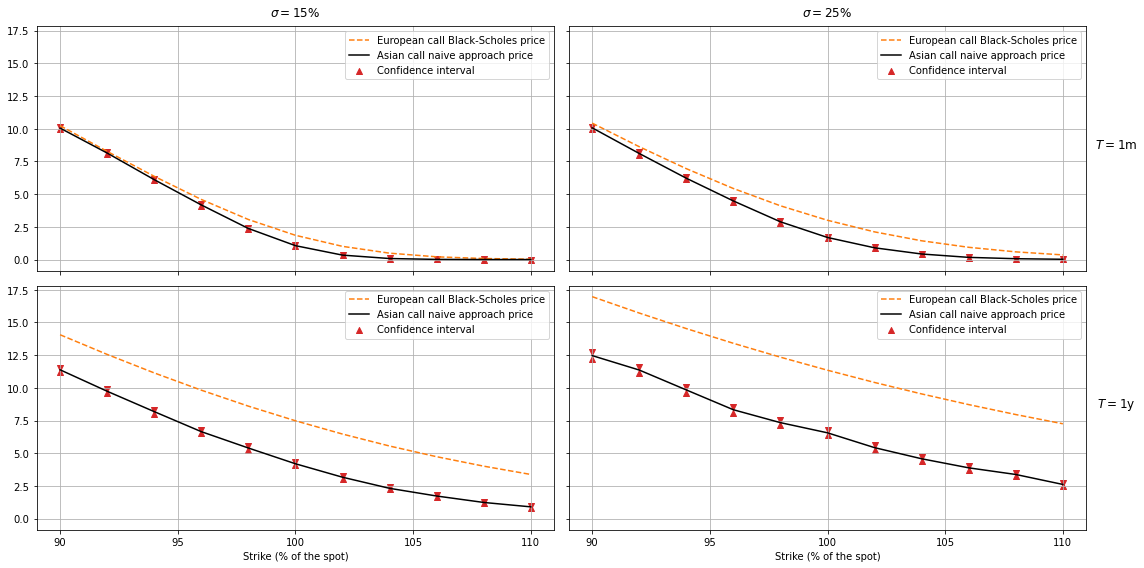

In [9]:
fixed_n, fixed_m, fixed_r, fixed_S0 = 10**4, 50, .03, 100
Ks = np.linspace(90, 110, 11)

start = perf_counter()

result = {}
for fixed_T in [1/12, 1]:
    for fixed_sigma in [.15, .25]:
        fixed = []
        for K in Ks:
            est, ci = trapeze(fixed_n, fixed_m, fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
            bs = vanilla(fixed_r, fixed_sigma, K, fixed_T, fixed_S0)
            fixed.append([est, bs, ci])
        fixed = np.array(fixed)
        result[(fixed_T, fixed_sigma)] = fixed

dur = perf_counter() - start
print(f'Duration: {dur:.2f} s')
plot_approach(result, Ks, [.15, .25], [1/12, 1])

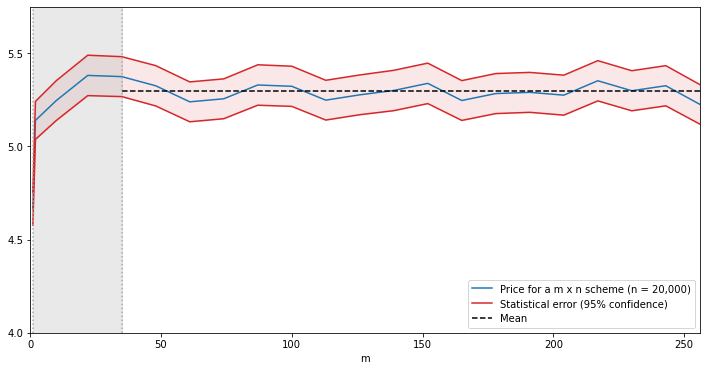

In [10]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 2*10**4, .03, 100, 1, .2, 100

ms = np.concatenate([[1, 2], np.linspace(10, 256, 20)]).astype('int')
fixed = []
for m in ms:
    est, ci = trapeze(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
    fixed.append([est, ci])
bs = vanilla(fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
fixed = np.array(fixed)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ms, fixed[:, 0], label=r'Price for a m x n scheme (n = 20,000)')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:red', label=r'Statistical error (95% confidence)')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:red')
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:red', alpha=.1)
ax.plot(ms[4:], np.mean(fixed[4:, 0])*np.ones(shape=ms[4:].shape), linestyle='--', color='black', label='Mean')
ax.set_xlabel('m')
ax.set_xlim(0, 256)
ax.set_ylim(4, 5.75)
ax.set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
ax.plot([1, 1], [4, 6], linestyle=':', color='darkgray')
ax.plot([ms[4], ms[4]], [4, 6], linestyle=':', color='darkgray')
ax.fill_between([1, ms[4]], [4, 4], [6, 6], color='darkgray', alpha=.25)
# ax.annotate(text='bias $\gg$ variance', xy=(18, 5.5))
ax.legend(loc='lower right');

In [11]:
np.mean(fixed[4:, 0])

5.294911785865429

### 2.b Conditional realization of the multiplicative correction factor

In [12]:
def conditional(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float]:  # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    rand = np.sqrt(h)*np.random.randn(m, n)/2
    e = s[:-1, ::]*(1 + r*h/2 + dw/2 + rand)    # AMENDMENT HERE 
    means = e.mean(axis=0)                      # estimatation of the mean value of the underlying
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    return c.mean(), 1.96*c.std()/np.sqrt(n)

### Results

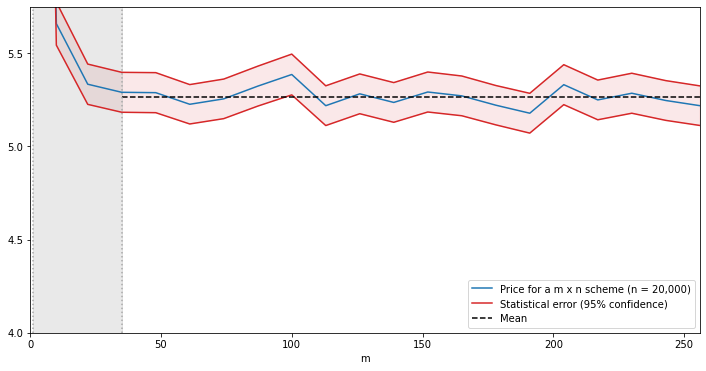

In [22]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 2*10**4, .03, 100, 1, .2, 100

ms = np.concatenate([[1, 2], np.linspace(10, 256, 20)]).astype('int')
fixed = []
for m in ms:
    est, ci = conditional(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)
    fixed.append([est, ci])
fixed = np.array(fixed)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ms, fixed[:, 0], label=r'Price for a m x n scheme (n = 20,000)')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:red', label=r'Statistical error (95% confidence)')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:red')
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:red', alpha=.1)
ax.plot(ms[4:], np.mean(fixed[4:, 0])*np.ones(shape=ms[4:].shape), linestyle='--', color='black', label='Mean')
ax.set_xlabel('m')
ax.set_xlim(0, 256)
ax.set_ylim(4, 5.75)
ax.set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
ax.plot([1, 1], [4, 6], linestyle=':', color='darkgray')
ax.plot([ms[4], ms[4]], [4, 6], linestyle=':', color='darkgray')
ax.fill_between([1, ms[4]], [4, 4], [6, 6], color='darkgray', alpha=.25)
# ax.annotate(text='bias $\gg$ variance', xy=(18, 5.5))
ax.legend(loc='lower right');

We achieve low bias for low values of $m$, the main focus should be reducing the variance. Hence the control variate approach below.

## 3. Control variates

In [14]:
def control_expectation(
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> float:
    a = (r - sigma**2/2)*T/2
    b = sigma*np.sqrt(T/3)
    rho = K/S0
    xstar = (np.log(rho) - a)/b
    return np.exp(-r*T)*(S0*np.exp(a + b**2/2)*norm.cdf(b - xstar) - K*norm.cdf(-xstar))

In [15]:
# Test (looks good)

control_expectation(.03, .2, 100, 1, 100)

5.086478856771596

In [16]:
def control_coeff(main_var: np.ndarray, control_var: np.ndarray) -> float:
    cov = np.cov([main_var, control_var])
    return - cov[0, 1]/cov[0, 0]

### 3.a With the naive method

In [17]:
def naive_control(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float, float, float, float]: 
    # returns the estimation and the half-length of the 95% confidence interval with and without control
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    means = s[:-1, ::].mean(axis=0)             # estimatation of the mean value of the underlying
    control_integral = S0*np.exp((r - sigma**2/2)*T/2 + w[:-1, ::].mean(axis=0))
    control = np.exp(-r*T)*np.maximum(control_integral - K, 0)
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    expectation = control_expectation(r, sigma, K, T, S0)
    beta = control_coeff(c, control)
    p = c + beta*(control - expectation)
    return p.mean(), 1.96*p.std()/np.sqrt(n), c.mean(), 1.96*c.std()/np.sqrt(n)

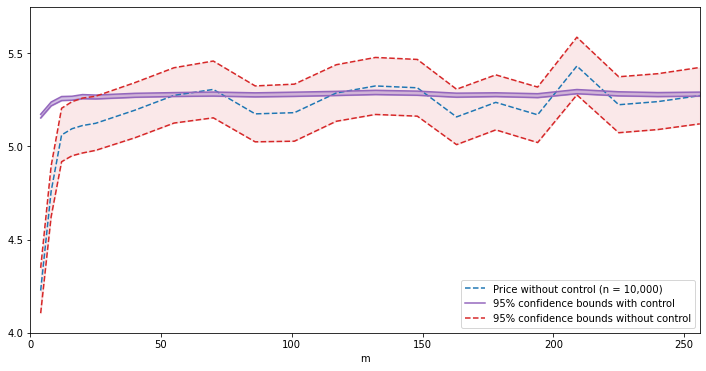

In [18]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 10**4, .03, 100, 1, .2, 100

ms = np.concatenate([np.linspace(4, 25, 6), np.linspace(40, 256, 15)]).astype('int')
fixed = []
for m in ms:
    fixed.append(list(naive_control(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)))
fixed = np.array(fixed)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ms, fixed[:, 2], label=r'Price without control (n = 10,000)', color='tab:blue', linestyle='--')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:purple', label=r'95% confidence bounds with control')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:purple')
ax.plot(ms, fixed[:, 2] + fixed[:, 3], color='tab:red', label=r'95% confidence bounds without control', linestyle='--')
ax.plot(ms, fixed[:, 2] - fixed[:, 3], color='tab:red', linestyle='--')
ax.fill_between(ms, fixed[:, 2] - fixed[:, 3], fixed[:, 2] + fixed[:, 3], color='tab:red', alpha=.1)
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:purple', alpha=.4)
ax.set_xlabel('m')
ax.set_xlim(0, 256)
ax.set_ylim(4, 5.75)
ax.set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
# ax.plot([4, 4], [4, 6], linestyle=':', color='darkgray')
# ax.plot([ms[-13], ms[-13]], [4, 6], linestyle=':', color='darkgray')
# ax.fill_between([4, ms[-13]], [4, 4], [6, 6], color='darkgray', alpha=.25)
# ax.annotate(text='bias $\gg$ variance', xy=(18, 5.5))
ax.legend(loc='lower right');
# axins = ax.inset_axes(
#     [50, 4.2, 50, .5],
#     xlim=(100, 150), ylim=(5.25, 5.32), transform=ax.transData)
# axins.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:purple', alpha=.4)
# axins.set_xticks([])
# axins.set_yticks([])
# ax.indicate_inset_zoom(axins, edgecolor="black");

The result is truly outstanding: we can take much lower values of $n$ and $m$ and achieve way better performances!

### 3.b With the trapezoidal method

In [19]:
def trapeze_control(
        n: int,            # number of Monte-Carlo simulations
        m: int,            # number of time steps
        r: float,          # risk-free interest rate
        sigma: float,      # volatility of the underlying
        K: float,          # strike of the fixed-strike Asian call
        T: float,          # maturity of the option
        S0: float          # spot at time t=0
) -> tuple[float, float, float, float]:
    # returns the estimation and the half-length of the 95% confidence interval
    h = T/m
    dw = np.sqrt(h)*sigma*np.random.randn(m, n) # brownian motion increments x sigma (independent)
    wt = np.cumsum(dw, axis=0)                  # brownian motion values for time t = 1, ..., m
    w = np.insert(wt, obj=0, values=0, axis=0)  # add W0 = 0 at the top of each column -> shape (m + 1, n)
    drift = (r - sigma**2/2)*h*np.arange(m + 1).reshape((m + 1, 1))
    s = S0*np.exp(drift + w)                    # trajectory at time t = 0, ..., m
    e = s[:-1, ::]*(1 + r*h/2 + dw/2)           # AMENDMENT HERE 
    means = e.mean(axis=0)                      # estimatation of the mean value of the underlying
    control_integral = S0*np.exp((r - sigma**2/2)*T/2 + .5*np.mean(w[1:, ::] + w[:-1, ::], axis=0))
    control = np.exp(-r*T)*np.maximum(control_integral - K, 0)
    c = np.exp(-r*T)*np.maximum(means - K, 0)   # price for each simulation
    expectation = control_expectation(r, sigma, K, T, S0)
    beta = control_coeff(c, control)
    p = c + beta*(control - expectation)
    return p.mean(), 1.96*p.std()/np.sqrt(n), c.mean(), 1.96*c.std()/np.sqrt(n)

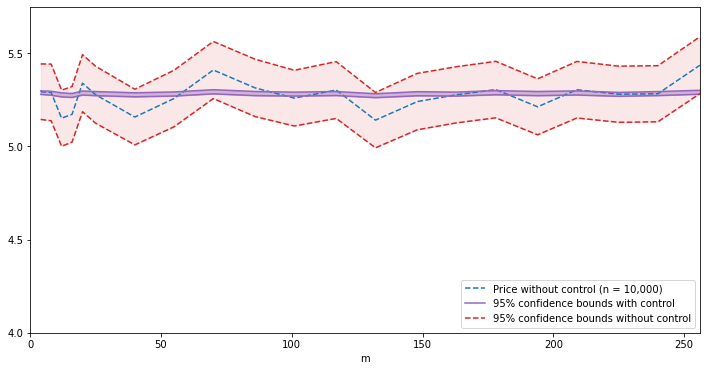

In [20]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 10**4, .03, 100, 1, .2, 100

ms = np.concatenate([np.linspace(4, 25, 6), np.linspace(40, 256, 15)]).astype('int')
fixed = []
for m in ms:
    fixed.append(list(trapeze_control(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)))
fixed = np.array(fixed)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ms, fixed[:, 2], label=r'Price without control (n = 10,000)', color='tab:blue', linestyle='--')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:purple', label=r'95% confidence bounds with control')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:purple')
ax.plot(ms, fixed[:, 2] + fixed[:, 3], color='tab:red', label=r'95% confidence bounds without control', linestyle='--')
ax.plot(ms, fixed[:, 2] - fixed[:, 3], color='tab:red', linestyle='--')
ax.fill_between(ms, fixed[:, 2] - fixed[:, 3], fixed[:, 2] + fixed[:, 3], color='tab:red', alpha=.1)
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:purple', alpha=.4)
ax.set_xlabel('m')
ax.set_xlim(0, 256)
ax.set_ylim(4, 5.75)
ax.set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
# ax.plot([4, 4], [4, 6], linestyle=':', color='darkgray')
# ax.plot([ms[-13], ms[-13]], [4, 6], linestyle=':', color='darkgray')
# ax.fill_between([4, ms[-13]], [4, 4], [6, 6], color='darkgray', alpha=.25)
# ax.annotate(text='bias $\gg$ variance', xy=(18, 5.5))
ax.legend(loc='lower right');

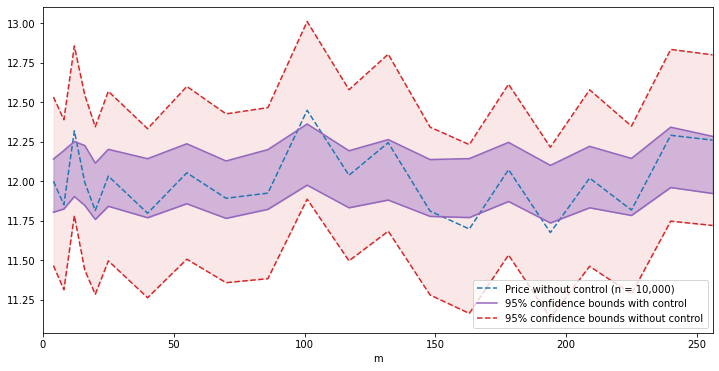

In [21]:
fixed_n, fixed_r, fixed_K, fixed_T, fixed_sigma, fixed_S0 = 10**4, .2, 120, 1, .7, 100

ms = np.concatenate([np.linspace(4, 25, 6), np.linspace(40, 256, 15)]).astype('int')
fixed = []
for m in ms:
    fixed.append(list(trapeze_control(fixed_n, m, fixed_r, fixed_sigma, fixed_K, fixed_T, fixed_S0)))
fixed = np.array(fixed)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ms, fixed[:, 2], label=r'Price without control (n = 10,000)', color='tab:blue', linestyle='--')
ax.plot(ms, fixed[:, 0] + fixed[:, 1], color='tab:purple', label=r'95% confidence bounds with control')
ax.plot(ms, fixed[:, 0] - fixed[:, 1], color='tab:purple')
ax.plot(ms, fixed[:, 2] + fixed[:, 3], color='tab:red', label=r'95% confidence bounds without control', linestyle='--')
ax.plot(ms, fixed[:, 2] - fixed[:, 3], color='tab:red', linestyle='--')
ax.fill_between(ms, fixed[:, 2] - fixed[:, 3], fixed[:, 2] + fixed[:, 3], color='tab:red', alpha=.1)
ax.fill_between(ms, fixed[:, 0] - fixed[:, 1], fixed[:, 0] + fixed[:, 1], color='tab:purple', alpha=.4)
ax.set_xlabel('m')
ax.set_xlim(0, 256)
# ax.set_ylim(4, 5.75)
# ax.set_yticks(np.arange(4, 5.6, step=.5), np.arange(4, 5.6, step=.5))
# ax.plot([4, 4], [4, 6], linestyle=':', color='darkgray')
# ax.plot([ms[-13], ms[-13]], [4, 6], linestyle=':', color='darkgray')
# ax.fill_between([4, ms[-13]], [4, 4], [6, 6], color='darkgray', alpha=.25)
# ax.annotate(text='bias $\gg$ variance', xy=(18, 5.5))
ax.legend(loc='lower right');

### 3.c With the "conditional realization" method